In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import plotly.express as px
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [2]:
listening_history = pd.read_csv('../data/listening_history.csv', sep='\t')
id_metadata = pd.read_csv('../data/id_metadata.csv', sep='\t')

In [3]:
listening_history.head()

,user,song,timestamp
0,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-20 12:28
1,user_007XIjOr,dGeyvi5WCOjDU7da,2019-02-20 12:35
2,user_007XIjOr,qUm54NYOjeFhmKYx,2019-02-20 12:48
3,user_007XIjOr,FtnuMT1DlevSR2n5,2019-02-20 12:52
4,user_007XIjOr,LHETTZcSZLeaVOGh,2019-02-20 13:09


In [4]:
id_metadata.head()

,id,spotify_id,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms
0,0009fFIM1eYThaPg,3eObKIfHKJ1nAPh0wTxFCc,12.0,2009,0.635,0.746,6.0,1.0,0.548,110.973,229947
1,0010xmHR6UICBOYT,27szvF97Tu95GxN98N52fy,46.0,2013,0.591,0.513,7.0,0.0,0.263,172.208,325096
2,002Jyd0vN4HyCpqL,273lBFpxUCwisTpdnF9cVb,31.0,1974,0.319,0.925,2.0,1.0,0.658,157.630,285693
3,006TYKNjNxWjfKjy,1qZgergQ41vaD4zBf3AKXR,33.0,2017,0.432,0.979,7.0,1.0,0.162,90.008,332867
4,007LIJOPQ4Sb98qV,6rVxJ3sN3Cz40MSLavbG1K,19.0,2009,0.357,0.708,9.0,1.0,0.470,123.904,326067


In [20]:
selected_features = id_metadata.copy()
selected_features = selected_features.drop(columns=['spotify_id'])
selected_features.set_index("id", inplace=True)
selected_features

,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms
id,,,,,,,,,
0009fFIM1eYThaPg,12.0,2009,0.635,0.746,6.0,1.0,0.548,110.973,229947
0010xmHR6UICBOYT,46.0,2013,0.591,0.513,7.0,0.0,0.263,172.208,325096
002Jyd0vN4HyCpqL,31.0,1974,0.319,0.925,2.0,1.0,0.658,157.630,285693
006TYKNjNxWjfKjy,33.0,2017,0.432,0.979,7.0,1.0,0.162,90.008,332867
007LIJOPQ4Sb98qV,19.0,2009,0.357,0.708,9.0,1.0,0.470,123.904,326067
...,...,...,...,...,...,...,...,...,...
zzyyPUs7hC9Nz2e1,36.0,2017,0.380,0.835,1.0,1.0,0.539,142.699,200880
zzz0n04uuTUA7fNh,48.0,2014,0.572,0.503,6.0,0.0,0.553,103.215,262840
zzzj3LYaZtYtbzSr,21.0,2010,0.402,0.376,2.0,0.0,0.119,108.509,276507


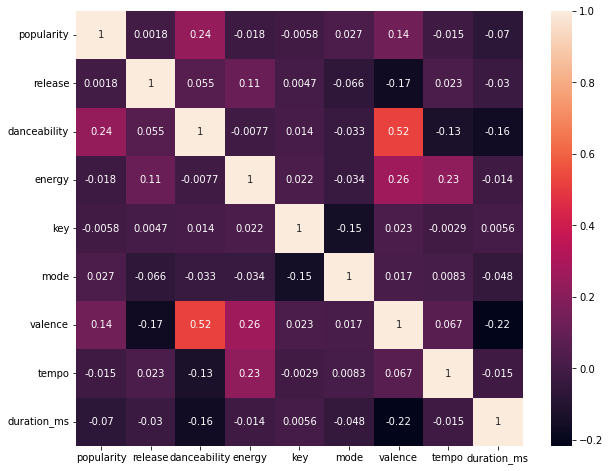

In [43]:
plt.figure(figsize=(10, 8)) 
ax = sns.heatmap(selected_features.corr(), annot=True)
plt.show()

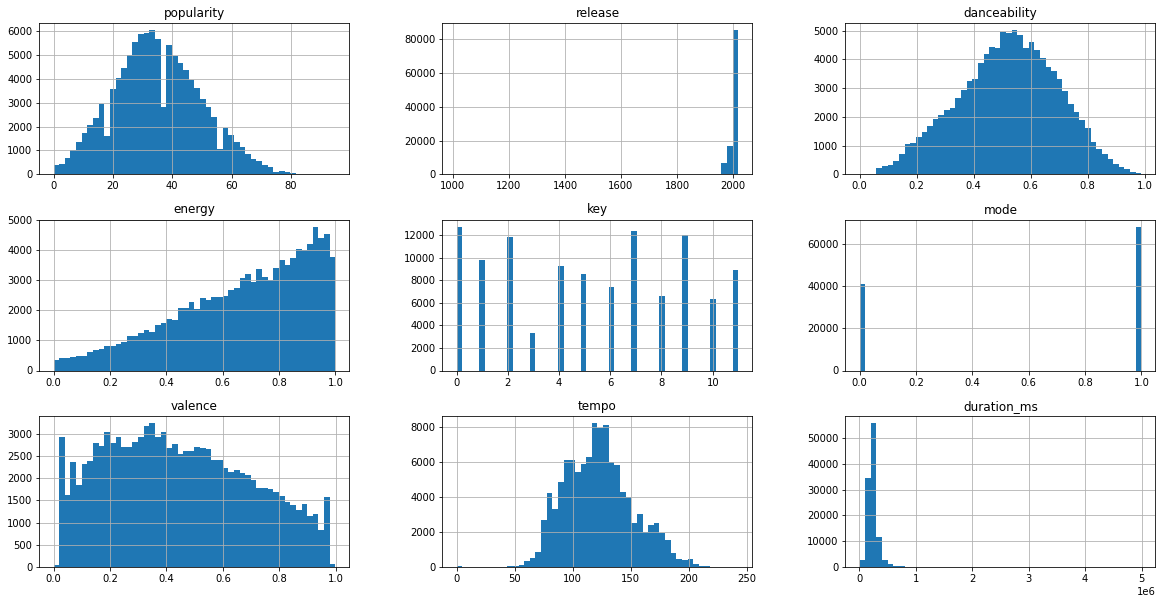

In [22]:
selected_features.hist(bins=50, figsize=(20,10))
plt.show()

In [39]:
columns_to_cluster = ['popularity', 'release', 'danceability', 'energy',
                      'key', 'mode', 'valence', 'tempo', 'duration_ms']

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
songs_scaled = scaler.fit_transform(selected_features)

In [44]:
columns_to_cluster_scaled = ['scaled_popularity', 'scaled_release', 'scaled_danceability', 'scaled_energy',
                      'scaled_key', 'scaled_mode', 'scaled_valence', 'scaled_tempo', 'scaled_duration_ms']

df_songs_scaled = pd.DataFrame(songs_scaled, columns=columns_to_cluster_scaled)
df_songs_scaled.head()

,scaled_popularity,scaled_release,scaled_danceability,scaled_energy,scaled_key,scaled_mode,scaled_valence,scaled_tempo,scaled_duration_ms
0,-1.564131,0.222289,0.662116,0.326627,0.201057,0.775143,0.406477,-0.406239,-0.125156
1,0.739987,0.501327,0.407792,-0.638693,0.481895,-1.290084,-0.723768,1.705473,0.823152
2,-0.276535,-2.219289,-1.164394,1.068225,-0.922292,0.775143,0.842712,1.202745,0.430439
3,-0.140999,0.780364,-0.511243,1.291948,0.481895,0.775143,-1.124311,-1.129225,0.900602
4,-1.089753,0.222289,-0.944751,0.169193,1.043569,0.775143,0.097147,0.039692,0.832829


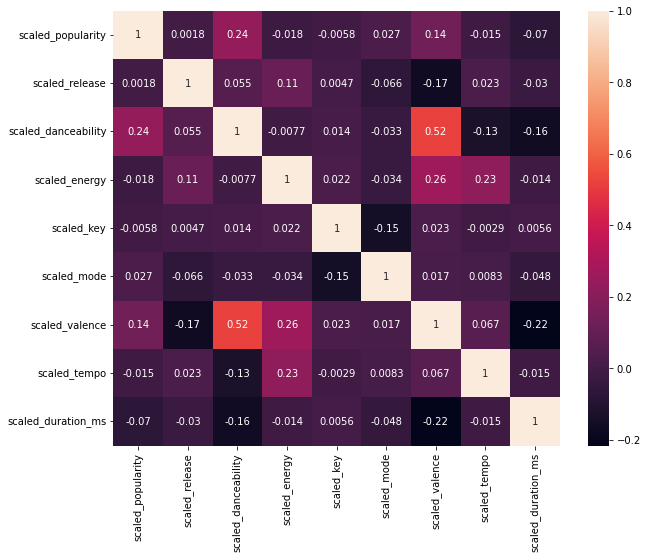

In [42]:
plt.figure(figsize=(10, 8)) 
ax = sns.heatmap(df_songs_scaled.corr(), annot=True)
plt.show()

In [59]:
from sklearn.cluster import KMeans

n_clusters = range(1, 20)

wcss = []  # Within-cluster sum of squares
for i in n_clusters:  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(songs_scaled)
    wcss.append(kmeans.inertia_)


In [61]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters = range(2,10)
ssd = []
sc = []


for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(songs_scaled)
    preds = km.predict(songs_scaled) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(songs_scaled, preds, metric='euclidean')
    sc.append(score)
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

Number of Clusters = 2, Silhouette Score = 0.12582544643386753
Number of Clusters = 3, Silhouette Score = 0.12205862626556353
Number of Clusters = 4, Silhouette Score = 0.1230417236876999
Number of Clusters = 5, Silhouette Score = 0.12342854829317743
Number of Clusters = 6, Silhouette Score = 0.12676007547137313
Number of Clusters = 7, Silhouette Score = 0.12285055671392266
Number of Clusters = 8, Silhouette Score = 0.11738288147673288
Number of Clusters = 9, Silhouette Score = 0.11124239879272696


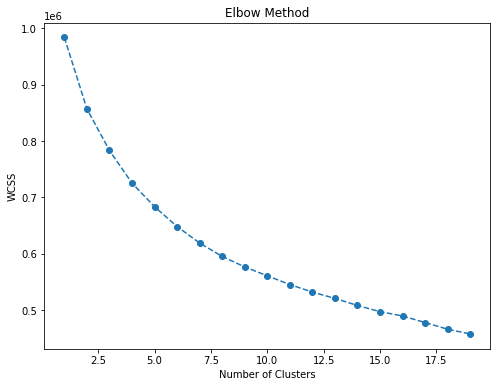

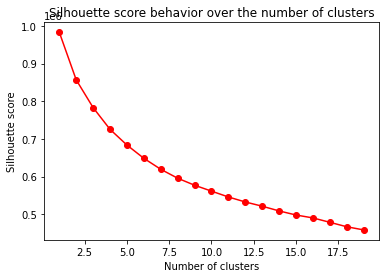

In [60]:
plt.figure(figsize=(10, 8))
plt.plot(n_clusters, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()